# WIP - Transfer learning with TF-Slim for NCS

Status: Only the first checkpoint "model.ckpt-0" produces output. Later checkpoints, eg, "model.ckpt-2" output `nan`.

### Download Inception V1 checkpoint

In [13]:
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading inception_v1_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v1_2016_08_28.tar.gz 24642554 bytes.


### Download the Flowers dataset from TF-Slim

In [8]:
import sys
sys.path.insert(0,'/home/justin/ncs/models-master/research/slim/datasets')

In [9]:
import tensorflow as tf
from datasets import dataset_utils

url = "http://download.tensorflow.org/data/flowers.tar.gz"
flowers_data_dir = '/tmp/flowers'

if not tf.gfile.Exists(flowers_data_dir):
    tf.gfile.MakeDirs(flowers_data_dir)

dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir) 

>> Downloading flowers.tar.gz 100.0%
Successfully downloaded flowers.tar.gz 228649660 bytes.


In [14]:
from preprocessing import inception_preprocessing
import tensorflow as tf

from tensorflow.contrib import slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

### Fine-tune the ImageNet-trained Inception V1 model on flowers.

In [16]:
# Note that this may take several minutes.

import os

from datasets import flowers
from nets import inception
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim
image_size = inception.inception_v1.default_image_size


def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
      variables_to_restore)


train_dir = '/tmp/inception_finetuned/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    images = tf.identity(images, name='input')
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total_Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=2)

  
print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Restoring parameters from /tmp/inception_finetuned/model.ckpt-20
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/inception_finetuned/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 20.
INFO:tensorflow:global step 21: loss = 2.2169 (16.272 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
Finished training. Last batch loss 2.216947


### Apply fine tuned model to some images.

224


/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Instructions for updating:
Use `tf.local_variables_initializer` instead.


Instructions for updating:
Use `tf.local_variables_initializer` instead.


INFO:tensorflow:Restoring parameters from /tmp/inception_finetuned/model.ckpt-0


INFO:tensorflow:Restoring parameters from /tmp/inception_finetuned/model.ckpt-0


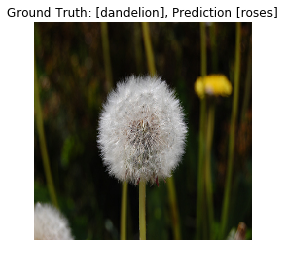

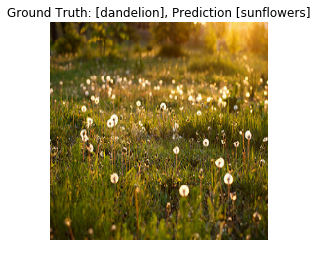

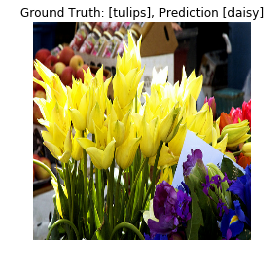

In [33]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datasets import flowers
from nets import inception
from tensorflow.contrib import slim

image_size = inception.inception_v1.default_image_size
print(image_size)
batch_size = 3

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=False)

    probabilities = tf.nn.softmax(logits)
    
#     checkpoint_path = tf.train.latest_checkpoint(train_dir) # Doesn't work with this
    checkpoint_path = '/tmp/inception_finetuned/model.ckpt-0' # Works with this
    init_fn = slim.assign_from_checkpoint_fn(
        checkpoint_path,
        slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()

In [34]:
import numpy as np
import tensorflow as tf

from tensorflow.contrib.slim.nets import inception

slim = tf.contrib.slim

def run(name, image_size, num_classes):
    global sess2
    with tf.Graph().as_default():
        image = tf.placeholder(
            "float", [1, image_size, image_size, 3], name="input")
        with slim.arg_scope(inception.inception_v1_arg_scope()):
            logits, _ = inception.inception_v1(
                image, num_classes, is_training=False, spatial_squeeze=False)
        probabilities = tf.nn.softmax(logits)
#         model_path = tf.train.latest_checkpoint('/tmp/inception_finetuned/') # Doesn't work
        model_path = '/tmp/inception_finetuned/model.ckpt-0'
        init_fn = slim.assign_from_checkpoint_fn(
            model_path, slim.get_model_variables('InceptionV1'))

        with tf.Session() as sess:
            init_fn(sess)
            saver = tf.train.Saver(tf.global_variables())
            saver.save(sess, "/tmp/output/" + name)

# Saves checkpoint and meta to `flowers_inception_v1`
run('flowers_inception_v1', 224, 5)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


INFO:tensorflow:Restoring parameters from /tmp/inception_finetuned/model.ckpt-0


INFO:tensorflow:Restoring parameters from /tmp/inception_finetuned/model.ckpt-0


## Run mvNCCompile on the `meta` file

In [43]:
from subprocess import Popen
sts = Popen("mvNCCompile" + " /tmp/output/flowers_inception_v1.meta -in input -on InceptionV1/Logits/Predictions/Reshape_1 -s 12 -o flowers_inception_v1_graph", shell=True).wait()
assert(os.path.exists('./flowers_inception_v1_graph'))

## Load graph on NCS and test inference with flower images

classes

daisy

dandelion

roses

sunflowers

tulips

Number of categories: 5


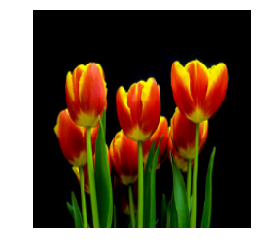

Start download to NCS...
[ nan  nan  nan  nan  nan]
TOP INDS: [4 3 2 1 0]
*******************************************************************************
inception-v1 on NCS
*******************************************************************************
4 tulips nan
3 sunflowers nan
2 roses nan
1 dandelion nan
0 daisy nan
*******************************************************************************
classes

daisy

dandelion

roses

sunflowers

tulips

Number of categories: 5


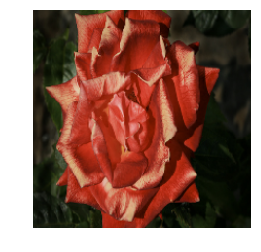

Start download to NCS...
[ nan  nan  nan  nan  nan]
TOP INDS: [4 3 2 1 0]
*******************************************************************************
inception-v1 on NCS
*******************************************************************************
4 tulips nan
3 sunflowers nan
2 roses nan
1 dandelion nan
0 daisy nan
*******************************************************************************
classes

daisy

dandelion

roses

sunflowers

tulips

Number of categories: 5


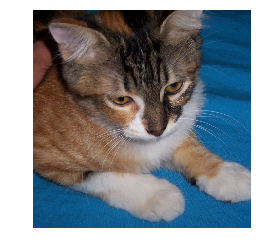

Start download to NCS...
[ 0.2590332   0.26147461  0.17504883  0.14416504  0.16027832]
TOP INDS: [1 0 2 4 3]
*******************************************************************************
inception-v1 on NCS
*******************************************************************************
1 dandelion 0.26147
0 daisy 0.25903
2 roses 0.17505
4 tulips 0.16028
3 sunflowers 0.14417
*******************************************************************************
classes

daisy

dandelion

roses

sunflowers

tulips

Number of categories: 5


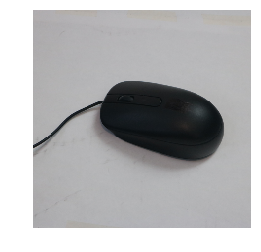

Start download to NCS...
[ 0.2590332   0.26147461  0.17504883  0.14416504  0.16027832]
TOP INDS: [1 0 2 4 3]
*******************************************************************************
inception-v1 on NCS
*******************************************************************************
1 dandelion 0.26147
0 daisy 0.25903
2 roses 0.17505
4 tulips 0.16028
3 sunflowers 0.14417
*******************************************************************************
classes

daisy

dandelion

roses

sunflowers

tulips

Number of categories: 5


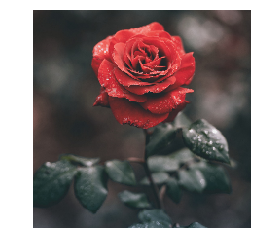

Start download to NCS...
[ 0.29541016  0.13989258  0.26293945  0.18566895  0.1161499 ]
TOP INDS: [0 2 3 1 4]
*******************************************************************************
inception-v1 on NCS
*******************************************************************************
0 daisy 0.29541
2 roses 0.26294
3 sunflowers 0.18567
1 dandelion 0.13989
4 tulips 0.11615
*******************************************************************************
classes

daisy

dandelion

roses

sunflowers

tulips

Number of categories: 5


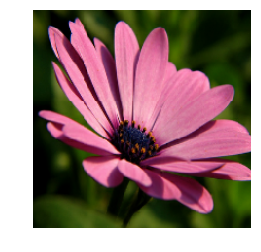

Start download to NCS...
[ 0.29541016  0.13989258  0.26293945  0.18566895  0.1161499 ]
TOP INDS: [0 2 3 1 4]
*******************************************************************************
inception-v1 on NCS
*******************************************************************************
0 daisy 0.29541
2 roses 0.26294
3 sunflowers 0.18567
1 dandelion 0.13989
4 tulips 0.11615
*******************************************************************************
Finished


In [44]:
from mvnc import mvncapi as mvnc

import glob
import time
import sys
import numpy
import cv2
import matplotlib.pyplot as plt

def run_inference(image_filename):
    path_to_networks = './'
    path_to_images = 'data/images/'
    graph_filename = 'flowers_inception_v1_graph'

    mvnc.SetGlobalOption(mvnc.GlobalOption.LOG_LEVEL, 2)
    
    #Load graph
    with open(path_to_networks + graph_filename, mode='rb') as f:
        graphfile = f.read()

    #Load preprocessing data
    mean = 128 
    std = 1/128 

    #Load categories
    categories = []
    with open(path_to_networks + 'categories.txt', 'r') as f:
        for line in f:
            print(line)
            cat = line.split('\n')[0]
            if cat != 'classes':
                categories.append(cat)
        f.close()
        print('Number of categories:', len(categories))

    #Load image size
    with open(path_to_networks + 'inputsize.txt', 'r') as f:
        reqsize = int(f.readline().split('\n')[0])
    graph = device.AllocateGraph(graphfile)

    img = cv2.imread(image_filename).astype(numpy.float32)
    
    dx,dy,dz= img.shape
    delta=float(abs(dy-dx))
    if dx > dy: #crop the x dimension
        img=img[int(0.5*delta):dx-int(0.5*delta),0:dy]
    else:
        img=img[0:dx,int(0.5*delta):dy-int(0.5*delta)]

    img = cv2.resize(img, (reqsize, reqsize))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    # Preview image
    plt.axis("off")
    plt.imshow(img.astype(numpy.uint8))
    plt.show()
    
    for i in range(3):
        img[:,:,i] = (img[:,:,i] - mean) * std
        
    print('Start download to NCS...')
    graph.LoadTensor(img.astype(numpy.float16), 'user object')
    output, userobj = graph.GetResult()
    print(output)
    top_inds = output.argsort()[::-1][:5]
    print("TOP INDS:", top_inds)
    print(''.join(['*' for i in range(79)]))
    print('inception-v1 on NCS')
    print(''.join(['*' for i in range(79)]))
    for i in range(5):
        print(top_inds[i], categories[top_inds[i]], output[top_inds[i]])

    print(''.join(['*' for i in range(79)]))
    graph.DeallocateGraph()
    
# Load images
image_filenames = glob.glob('data/images/*')

devices = mvnc.EnumerateDevices()
if len(devices) == 0:
    print('No devices found')
    quit()

device = mvnc.Device(devices[0])
device.OpenDevice()
for image_filename in image_filenames:
    run_inference(image_filename)
    time.sleep(1)
device.CloseDevice()
print('Finished')